In [1]:
library(tidyverse)
library(here)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
here() starts at /home/dhawanjewar/EMBO_popgen24



In [2]:
data_dir <- here("Day6", "data")

AFR_EAS_FST <- read.table(here(data_dir, "AFR_EAS.weir.fst"), header = TRUE)
AFR_EUR_FST <- read.table(here(data_dir, "AFR_EUR.weir.fst"), header = TRUE)
EAS_EUR_FST <- read.table(here(data_dir, "EAS_EUR.weir.fst"), header = TRUE)

In [3]:

remove_NA_dups <- function(df) {

    df <- df %>% distinct(POS, .keep_all = TRUE) %>% na.omit()

    return(df)

}

FST_list <- list(AFR_EAS = AFR_EAS_FST,
                 AFR_EUR = AFR_EUR_FST,
                 EAS_EUR = EAS_EUR_FST)

clean_FST_list <- lapply(FST_list, remove_NA_dups)

In [4]:
# Get overlapping SNPs between datasets
overlap_POS <- Reduce(intersect, lapply(clean_FST_list, `[[`, "POS"))

# Subset the FST dfs to contain only the overlapping SNPs
overlap_FST_df <- lapply(clean_FST_list, function(df) {
  df[df$POS %in% overlap_POS, ]
})

In [5]:
# Set negative FST values to 0 
reset_neg_vals <- function(df) {
    df <- df %>%
    mutate(WEIR_AND_COCKERHAM_FST = pmax(WEIR_AND_COCKERHAM_FST, 0))
    return(df)
}

overlap_FST_df <- lapply(overlap_FST_df, reset_neg_vals)

In [6]:
pos_of_interest <- 109513601

# Get outliers 
get_outlier_vals <- function(df, thres = 0.95) {
    outlier_thres <- quantile(df$WEIR_AND_COCKERHAM_FST, thres)

    df_outliers <- df[df$WEIR_AND_COCKERHAM_FST > outlier_thres, ]
   
    return(df_outliers)
}

# Get quantiles
get_quartiles <- function(df, pos) {
    quartiles <- quantile(df$WEIR_AND_COCKERHAM_FST)
    pos_val <- df[df$POS == pos, "WEIR_AND_COCKERHAM_FST"]

    # Get the quartile in which pos_val lies
    pos_val_quartile <- findInterval(pos_val, quartiles)

    print(paste((names(quartiles)[pos_val_quartile]), 
          "-", 
          names(quartiles)[pos_val_quartile+1]))
} 

quartile_for_SNP <- lapply(overlap_FST_df, 
                          function(df) get_quartiles(df, pos = pos_of_interest))

outlier_SNPS <- lapply(overlap_FST_df, get_outlier_vals)

overlap_FST_df <- Map(function(df, outliers) {
  df$Is_Outlier <- df$POS %in% outliers$POS
  return(df)
}, overlap_FST_df, outlier_SNPS)

is_in_outliers <- lapply(outlier_SNPS, function(df) {
  pos_of_interest %in% df$POS
})

print(is_in_outliers)

[1] "75% - 100%"
[1] "0% - 25%"
[1] "75% - 100%"


$AFR_EAS
[1] TRUE

$AFR_EUR
[1] FALSE

$EAS_EUR
[1] TRUE



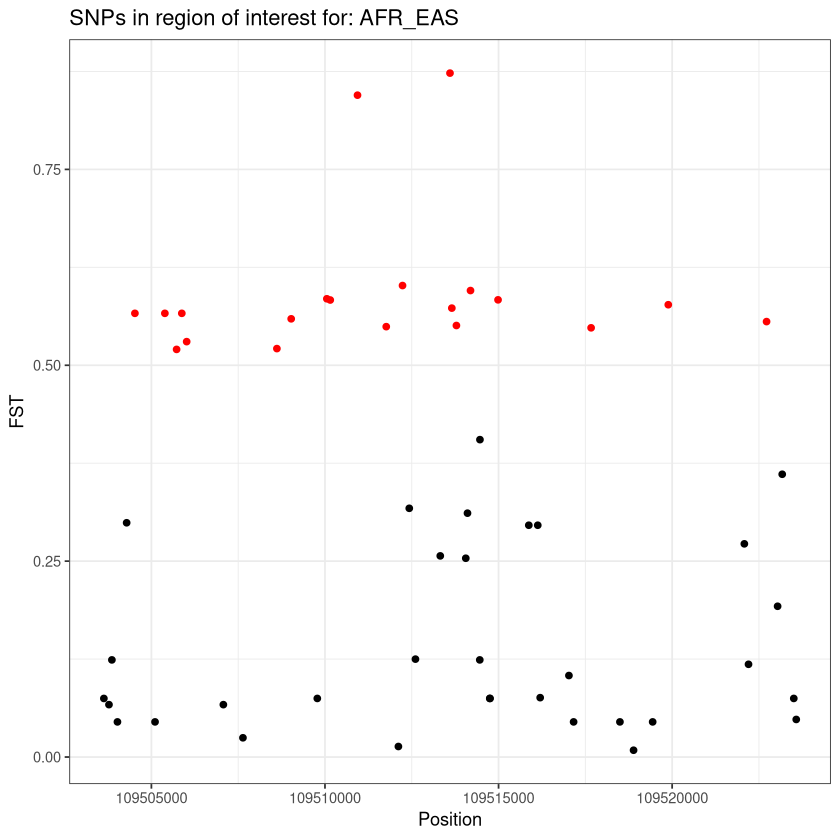

$AFR_EAS

$AFR_EUR

$EAS_EUR


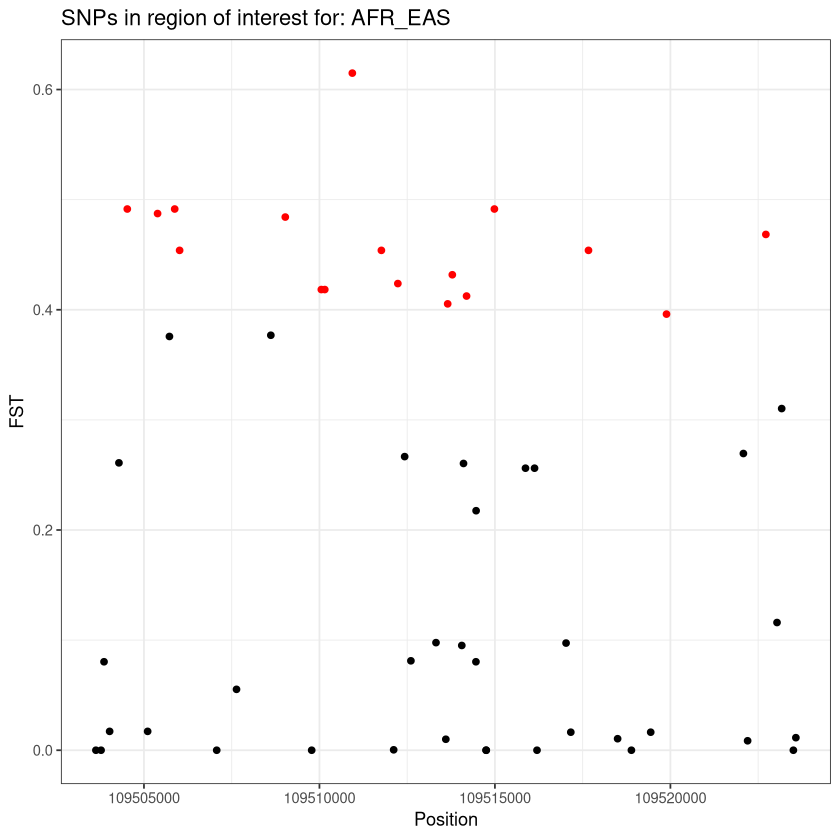

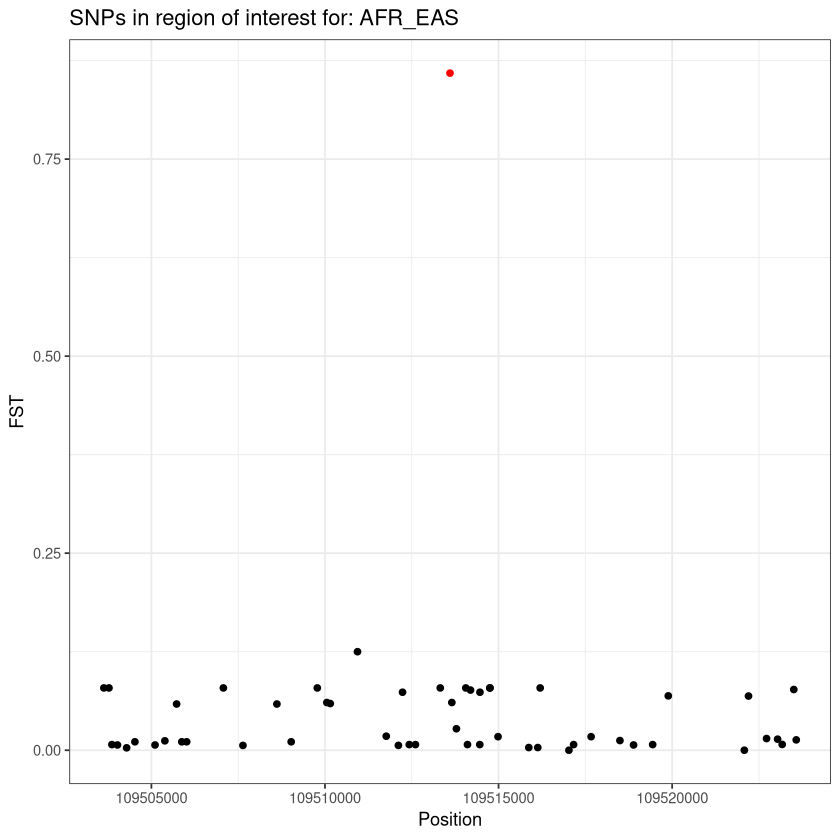

In [21]:
pos_window <- 10000

region_of_interest <- c(pos_of_interest - pos_window, pos_of_interest + pos_window)

subset_windows <- function(df, region) {
  df <- df[df$POS >= region[1] & df$POS <= region[2], ]
  return(df)
}

plot_SNPs_FST <- function(df, pop_pair = NULL) {

  ggplot(df, aes(x = POS, y = WEIR_AND_COCKERHAM_FST)) +
    geom_point(aes(color = Is_Outlier)) +
    theme_bw() +
    scale_color_manual(values = c("black", "red")) +
    labs(x = "Position",
         y = "FST") +
    ggtitle(paste0("SNPs in region of interest for: ", pop_pair)) +
    theme(legend.position = "none")
}

window_SNPs <- lapply(overlap_FST_df, subset_windows, region = region_of_interest)

lapply(window_SNPs, plot_SNPs_FST, pop_pair = names(window_SNPs))



Calculate PBS values 

[1] "90% - 100%"


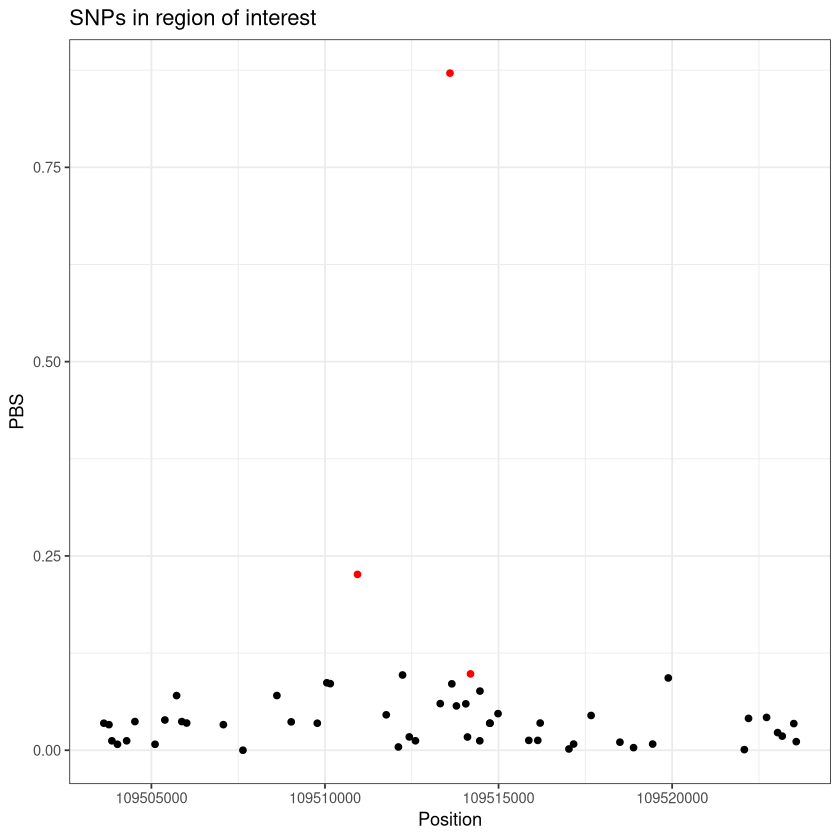

In [28]:
PBS_EAS <- ((-log10(1 - overlap_FST_df$AFR_EAS$WEIR_AND_COCKERHAM_FST)) +
            (-log10(1 - overlap_FST_df$EAS_EUR$WEIR_AND_COCKERHAM_FST)) -
            (-log10(1 - overlap_FST_df$AFR_EUR$WEIR_AND_COCKERHAM_FST))) / 2

PBS_EAS[PBS_EAS < 0] <- 0

combined_df <- overlap_FST_df[[1]] %>%
    inner_join(overlap_FST_df[[2]], by = c("CHROM", "POS")) %>%
    inner_join(overlap_FST_df[[3]], by = c("CHROM", "POS")) %>%
    rename_with(~paste0(.x, "_", names(overlap_FST_df)), -POS, .names = "unique") %>%
    select(-contains("Is_Outlier"))

combined_df$PBS_EAS <- PBS_EAS

PBS_pos_value <- combined_df$PBS_EAS[combined_df$POS == pos_of_interest]

get_PBS_quartiles <- function(df, pos) {
    quartiles <- quantile(df$PBS_EAS, probs = seq(0, 1, 0.1))
    pos_val <- df[df$POS == pos, "PBS_EAS"]

    # Get the quartile in which pos_val lies
    pos_val_quartile <- findInterval(pos_val, quartiles)

    print(paste((names(quartiles)[pos_val_quartile]), 
          "-", 
          names(quartiles)[pos_val_quartile+1]))
} 

get_PBS_quartiles(combined_df, pos = pos_of_interest)

plot_SNPs_PBS <- function(df) {
  ggplot(df, aes(x = POS, y = PBS_EAS)) +
    geom_point(aes(color = factor(ifelse(PBS_EAS > quantile(PBS_EAS, 0.95), "greater", "less")))) +
    scale_color_manual(values = c("greater" = "red", "less" = "black")) +
    theme_bw() +
    labs(x = "Position",
         y = "PBS") +
    ggtitle(paste0("SNPs in region of interest")) +
    theme(legend.position = "none")
}

window_PBS_SNPs <- subset_windows(combined_df, region = region_of_interest)

plot_SNPs_PBS(window_PBS_SNPs) 